In [121]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [122]:
# pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [177]:
train = pd.read_csv('F1108.csv', encoding='latin-1', low_memory=False)
test = pd.read_csv('T1108.csv', encoding='latin-1', low_memory=False)
# train = pd.read_csv('F1.csv', encoding='latin-1', low_memory=False)
# test = pd.read_csv('_data/SCORE_TEST.csv', encoding='latin-1', low_memory=False)

In [178]:
id_columns = ['MES', 'DOCUMENTOIDENT']
target_column = 'TARGET_MULTICLASE'
num_columns = [col for col in train._get_numeric_data().columns if col not in id_columns]
cat_columns = set(train.columns).difference(num_columns). \
                    difference(id_columns).difference([target_column])
cat_columns

{'BANCARIZADO',
 'CLA_RIESGO_IBK',
 'DEPARTAMENTO',
 'DISTRITO',
 'FLG_PROCEDENCIA',
 'PROFESION',
 'PROVINCIA',
 'RNG_EDAD',
 'RNG_INGRESO_BRUTO',
 'SCORE_CHURN_ACTIVO7',
 'SEGMENTO_CANAL',
 'SEGMENTO_CAPTACIONES',
 'SEGMENTO_CONSUMO_ACTIVO7',
 'SEGMENTO_FINAL',
 'SEGMENT_RFM_ACTIVO7',
 'SEXO',
 'SITUACION_LABORAL',
 'TIPO_VINCULACION',
 'VAR_0057',
 'VAR_0058'}

In [179]:
train.head()

,MES,DOCUMENTOIDENT,TARGET_MULTICLASE,DISTRITO,EDAD,DEPARTAMENTO,FLG_CELULAR,FLG_EMAIL,FLG_PROCEDENCIA,FLG_TELEFONO,RNG_EDAD,RNG_INGRESO_BRUTO,PROVINCIA,PROFESION,SEXO,SITUACION_LABORAL,CAMP_ACTIVO1,CAMP_ACTIVO2,CAMP_PASIVO14,CAMP_PASIVO3,CAMP_DIG,CAMP_ACTIVO3,CAMP_PASIVO4,CAMP_ACTIVO4,CAMP_ACTIVO9,CAMP_PASIVO9,CAMP_PASIVO5,CAMP_PASIVO8,CAMP_ACTIVO5,CAMP_PROACT,CAMP_REACT,CAMP_PASIVO11,CAMP_ACTIVO7,CAMP_PASIVO13,CAMP_ACTIVO8,CANT_CAMP_DIG,CANT_CAMP_PROACT,CANT_CAMP_REACT,CANT_PROD_CAMP,FLG_CAMP,VAR_0001,VAR_0002,VAR_0003,VAR_0004,VAR_0005,VAR_0006,VAR_0007,VAR_0008,VAR_0009,VAR_0010,VAR_0011,VAR_0012,VAR_0013,VAR_0014,VAR_0015,VAR_0016,VAR_0017,VAR_0018,VAR_0019,VAR_0020,VAR_0021,VAR_0022,VAR_0023,VAR_0024,VAR_0025,VAR_0026,VAR_0027,VAR_0028,VAR_0033,VAR_0034,VAR_0035,VAR_0036,VAR_0037,VAR_0038,VAR_0039,VAR_0040,VAR_0041,VAR_0042,VAR_0043,VAR_0044,VAR_0045,VAR_0046,VAR_0047,VAR_0048,VAR_0049,VAR_0050,VAR_0051,VAR_0052,VAR_0053,VAR_0054,VAR_0055,VAR_0056,VAR_0057,VAR_0058,VAR_0061,ACTIVO1,PASIVO1,PASIVO2,BANCARIZADO,CANT_CANJES,ACTIVO2,PASIVO3,RENT_IBK,RENT_POT,SALDOFDPTOTACT,SALDOFDPTOTACTIVO1,SALDOFDPTOTPASIVO1,SALDOFDPTOTACTIVO2,SALDOFDPTOTPASIVO3,SALDOFDPTOTACTIVO3,SALDOFDPTOTPASIVO4,SALDOFDPTOTACTIVO4,SALDOFDPTOTACTIVO5,SALDOFDPTOTPASIVO9,SALDOFDPTOTPAS,SALDOFDPTOTPASIVO6,SALDOFDPTOTPASIVO8,SALDOFDPTOTACTIVO7,SALDOFDPTOTPASIVO13,SALDOFDPTOTACTIVO8,SALDOFDPVIGACT,SALDOFDPVIGACTIVO1,SALDOFDPVIGACTIVO2,SALDOFDPVIGACTIVO3,SALDOFDPVIGACTIVO4,SALDOFDPVIGACTIVO5,SALDOFDPVIGACTIVO7,SALDOFDPVIGACTIVO8,SALDOPROMTOTACT,SALDOPROMTOTACTIVO1,SALDOPROMTOTPASIVO1,SALDOPROMTOTACTIVO2,SALDOPROMTOTPASIVO3,SALDOPROMTOTACTIVO3,SALDOPROMTOTPASIVO4,SALDOPROMTOTACTIVO4,SALDOPROMTOTACTIVO5,SALDOPROMTOTPASIVO9,SALDOPROMTOTPAS,SALDOPROMTOTPASIVO6,SALDOPROMTOTPASIVO8,SALDOPROMTOTACTIVO7,SALDOPROMTOTPASIVO13,SALDOPROMTOTACTIVO8,SALDOPROMVIGACT,SALDOPROMVIGACTIVO1,SALDOPROMVIGACTIVO2,SALDOPROMVIGACTIVO3,SALDOPROMVIGACTIVO4,SALDOPROMVIGACTIVO5,SALDOPROMVIGACTIVO7,SALDOPROMVIGACTIVO8,ACTIVO3,PASIVO4,PASIVO5,PARQUEACTIVO7,PASIVO6,PASIVO7,PASIVO8,ACTIVO4,INGRESO_BRUTO,ACTIVO5,PASIVO9,PASIVO10,SCORE_CHURN_ACTIVO7,SEGMENTO_CANAL,SEGMENTO_CAPTACIONES,SEGMENTO_CONSUMO_ACTIVO7,SEGMENTO_FINAL,SEGMENT_RFM_ACTIVO7,ACTIVO6,PASIVO11,PRODUCTOS,PASIVO12,MTO_CANJE,TIPO_VINCULACION,PASIVO13,ACTIVO7,USO_APP,USO_APP_BPI,USO_BPI,USO_DIG,ACTIVO8,FLG_CANJE,CASTIGADO,CAP_ENDEU,CLA_RIESGO_IBK,CLA_RIESGO_IBK2,CLA_RIESGO_SF,CODEMPRESA_ACTIVO2_PRINC,CODEMPRESA_ACTIVO4_PRINC,CODEMPRESA_ACTIVO5_PRINC,CODEMPRESA_PRINC,CODEMPRESA_ACTIVO7_PRINC,CODEMPRESA_ACTIVO8_PRINC,LINEA_ACTIVO7_IBK,LINEA_ACTIVO7_SF,FLG_ACTIVO2_SF,FLG_ACTIVO4_SF,FLG_ACTIVO5_SF,FLG_ACTIVO7_SF,FLG_ACTIVO8_SF,SALDO_ACTIVO2_PRINC,SALDO_ACTIVO2_SF,SALDO_ENT_PRINC,SALDO_ACTIVO4_PRINC,SALDO_ACTIVO4_SF,SALDO_ACTIVO5_PRINC,SALDO_ACTIVO5_SF,SALDO_ACTIVO7_PRINC,SALDO_ACTIVO7_SF,SALDO_TOT_IBK,SALDO_TOT_SF,SALDO_ACTIVO8_PRINC,SALDO_ACTIVO8_SF,SOBREENDEUDADO,SOW_ACTIVO2_PRINC,SOW_ENT_PRINC,SOW_ACTIVO4_PRINC,SOW_ACTIVO5_PRINC,SOW_ACTIVO7_PRINC,SOW_ACTIVO8_PRINC
0,201710,IBK_DNI00022971305,TG2,COMAS,25,LIMA,1,1,LIMA Y CALLAO,0,2. 18 - 27,4. 4000 - 9999,LIMA,NaN,F,INDEPENDIENTE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,201710,IBK_DNI00028646379,TG1,SAN MARTIN DE

## Cross validation

In [180]:
for col in num_columns:
    train[col].fillna(0, inplace=True)
    test[col].fillna(0, inplace=True)
train.fillna('-1', inplace=True)
test.fillna('-1', inplace=True)

In [181]:
train[target_column].value_counts() / len(train)

TG1    0.622357
TG2    0.377162
TG3    0.000480
Name: TARGET_MULTICLASE, dtype: float64

In [182]:
from collections import defaultdict
mean_encoder = defaultdict(dict)
for col in cat_columns:
    for level in (pd.concat((train[col], test[col]))).unique():
        mean_encoder[col][level] = (train[train[col]==level][target_column].value_counts() / \
                                        len(train[train[col]==level])).to_dict()

In [183]:
classes = train[target_column].unique()
for col in cat_columns:
    for level in train[col].unique():
        idxs = list(train[train[col]==level].index)
        for _class in classes:
            train.loc[idxs, f'{col}-{_class}'] = mean_encoder[col][level].get(_class,0)
    for level in test[col].unique():
        idxs = list(test[test[col]==level].index)
        for _class in classes:
            test.loc[idxs, f'{col}-{_class}'] = mean_encoder[col][level].get(_class,0)

In [184]:
for col in cat_columns:
    train.drop(col, axis=1, inplace=True)
    test.drop(col, axis=1, inplace=True)

In [151]:
train.shape

(12488, 262)

In [ ]:
# from sklearn.preprocessing import LabelEncoder
# label_encoders = {col: LabelEncoder().fit(pd.concat((train[col], test[col]))) \
#                         for col in cat_columns}
# for col in cat_columns:
#     train[col] = label_encoders[col].transform(train[col])
#     test[col] = label_encoders[col].transform(test[col])

In [152]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, log_loss, classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold

In [153]:
kfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [154]:
# results = pd.DataFrame(columns=['dataset', 'model', 'params', 
#                                 'valid_logloss', 'valid_logloss_std',
#                                 'train_logloss', 'train_logloss_std',
#                                 'logloss_diff', 'time'])

In [99]:
## For LightGBM and CatBoost
columns = list(train.drop(id_columns + [target_column], axis=1).columns)
cat_indices = [i for i, col in enumerate(columns) if col in cat_columns]

In [155]:
def run_model(model, X, y, X_test, dataset_desc='', params_desc=''):
    # X_test para calcular las predicciones del test con el modelo de cada fold
    model_name = str(model.__class__).split('.')[-1].replace('>','').replace("'",'')
    print(model_name)
    logloss = []
    train_logloss = []
    y_test = np.zeros((len(X_test), n_classes)) # global
    start = time.time()
    for train_idx, test_idx in kfolds.split(X, y):
        model.fit(X.iloc[train_idx,:], y[train_idx], 
                  eval_set=[(X.iloc[test_idx], y.iloc[test_idx])],
                  eval_metric='multi_logloss', #(lightgbm multi_logloss, xgboost mlogloss)
                  early_stopping_rounds=30, #(lightgbm, xgboost)                  
#                   use_best_model=True,  #(catboost),
#                   cat_features=cat_indices,  #(catboost) global!,
#                   plot=True #(catboost)
                 )
        print(model.classes_)
        
        y_ = model.predict_proba(X.iloc[test_idx]) # num_iteration [:,1]
        if y_.shape[1] == 2:
            y_ = np.concatenate((y_, np.zeros((len(y_), 1))), axis=1)
        print('shape', y_.shape)
        logloss += [log_loss(y.iloc[test_idx], y_)]
    
        y_ = model.predict(X.iloc[test_idx])
        print()
        print(f'Valid Accuracy: {accuracy_score(y.iloc[test_idx], y_)}')
        print(classification_report(y.iloc[test_idx], y_))
        print(confusion_matrix(y.iloc[test_idx], y_))
        
        y_ = model.predict_proba(X.iloc[train_idx]) # [:,1]
        if y_.shape[1] == 2:
            y_ = np.concatenate((y_, np.zeros((len(y_), 1))), axis=1)
        train_logloss += [log_loss(y.iloc[train_idx], y_)]
        
        y_ = model.predict_proba(X_test) # [:,1]
        if y_.shape[1] == 2:
            y_ = np.concatenate((y_, np.zeros((len(y_), 1))), axis=1)
        y_test += y_
        
        print(f'Valid LL: {logloss[-1]:.6f} | Train LL: {train_logloss[-1]:.6f}')
        print()
        
    y_test /= 5 # promedio de las predicciones de los modelos de cada fold
    end = time.time()
    results.loc[len(results)] = [dataset_desc, model_name, params_desc,
#                                  np.mean(auc), np.std(auc), 
                                 np.mean(logloss), np.std(logloss),
#                                  np.mean(train_auc), np.std(train_auc), 
                                 np.mean(train_logloss), np.std(train_logloss),                                 
                                 np.mean(logloss) - np.mean(train_logloss),
                                 round(end - start, 2)]
    print(f'logloss: {np.mean(logloss)}, train_logloss: {np.mean(train_logloss)}')
    return y_test

In [156]:
test_columns = ['CODIGOSF', 'CODIGOCLIENTE', 'PROB_CANAL_1', 'PROB_CANAL_2', 'PROB_CANAL_3']

In [157]:
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

In [158]:
n_classes=3

In [159]:
target_dict = {
    'TG1': 0,
    'TG2': 1,
    'TG3': 2
}

In [191]:
keep

['CAMP_ACTIVO1',
 'CAMP_PASIVO13',
 'VAR_0001',
 'VAR_0002',
 'VAR_0003',
 'VAR_0004',
 'VAR_0007',
 'VAR_0008',
 'VAR_0011',
 'VAR_0033',
 'VAR_0036',
 'SALDOFDPTOTACTIVO1',
 'SALDOFDPTOTACTIVO3',
 'SALDOFDPTOTACTIVO4',
 'SALDOFDPTOTACTIVO5',
 'SALDOFDPTOTACTIVO7',
 'SALDOFDPTOTACTIVO8',
 'SALDOPROMTOTACTIVO1',
 'SALDOPROMTOTACTIVO3',
 'SALDOPROMTOTACTIVO4',
 'SALDOPROMTOTACTIVO5',
 'SALDOPROMTOTACTIVO8',
 'FLG_ACTIVO8_SF']

In [192]:
remove

['CAMP_PASIVO13',
 'VAR_0015',
 'CAMP_PASIVO13',
 'VAR_0015',
 'VAR_0009',
 'VAR_0010',
 'VAR_0011',
 'VAR_0014',
 'VAR_0012',
 'VAR_0016',
 'VAR_0017',
 'VAR_0009',
 'VAR_0010',
 'VAR_0011',
 'VAR_0014',
 'VAR_0012',
 'VAR_0014',
 'VAR_0014',
 'VAR_0015',
 'VAR_0015',
 'VAR_0016',
 'VAR_0017',
 'VAR_0034',
 'VAR_0034',
 'VAR_0040',
 'VAR_0040',
 'SALDOFDPVIGACTIVO1',
 'SALDOFDPVIGACTIVO3',
 'SALDOFDPVIGACTIVO4',
 'SALDOFDPVIGACTIVO5',
 'SALDOFDPVIGACTIVO7',
 'SALDOFDPVIGACTIVO8',
 'SALDOFDPVIGACTIVO1',
 'SALDOFDPVIGACTIVO3',
 'SALDOFDPVIGACTIVO4',
 'SALDOFDPVIGACTIVO5',
 'SALDOFDPVIGACTIVO7',
 'SALDOFDPVIGACTIVO8',
 'SALDOPROMVIGACTIVO1',
 'SALDOPROMVIGACTIVO3',
 'SALDOPROMVIGACTIVO4',
 'SALDOPROMVIGACTIVO5',
 'SALDOPROMVIGACTIVO8',
 'SALDOPROMVIGACTIVO1',
 'SALDOPROMVIGACTIVO3',
 'SALDOPROMVIGACTIVO4',
 'SALDOPROMVIGACTIVO5',
 'SALDOPROMVIGACTIVO8',
 'SOW_ACTIVO8_PRINC',
 'SOW_ACTIVO8_PRINC']

In [222]:
train.head()

,MES,DOCUMENTOIDENT,TARGET_MULTICLASE,EDAD,FLG_CELULAR,FLG_EMAIL,FLG_TELEFONO,CAMP_ACTIVO1,CAMP_ACTIVO2,CAMP_PASIVO14,CAMP_PASIVO3,CAMP_DIG,CAMP_ACTIVO3,CAMP_PASIVO4,CAMP_ACTIVO4,CAMP_ACTIVO9,CAMP_PASIVO9,CAMP_PASIVO5,CAMP_PASIVO8,CAMP_ACTIVO5,CAMP_PROACT,CAMP_REACT,CAMP_PASIVO11,CAMP_ACTIVO7,CAMP_ACTIVO8,CANT_CAMP_DIG,CANT_CAMP_PROACT,CANT_CAMP_REACT,CANT_PROD_CAMP,FLG_CAMP,VAR_0001,VAR_0002,VAR_0003,VAR_0004,VAR_0005,VAR_0006,VAR_0007,VAR_0008,VAR_0013,VAR_0018,VAR_0019,VAR_0020,VAR_0021,VAR_0022,VAR_0023,VAR_0024,VAR_0025,VAR_0026,VAR_0027,VAR_0028,VAR_0033,VAR_0034,VAR_0035,VAR_0036,VAR_0037,VAR_0038,VAR_0039,VAR_0040,VAR_0041,VAR_0042,VAR_0043,VAR_0044,VAR_0045,VAR_0046,VAR_0047,VAR_0048,VAR_0049,VAR_0050,VAR_0051,VAR_0052,VAR_0053,VAR_0054,VAR_0055,VAR_0056,VAR_0061,ACTIVO1,PASIVO1,PASIVO2,CANT_CANJES,ACTIVO2,PASIVO3,RENT_IBK,RENT_POT,SALDOFDPTOTACT,SALDOFDPTOTACTIVO1,SALDOFDPTOTPASIVO1,SALDOFDPTOTACTIVO2,SALDOFDPTOTPASIVO3,SALDOFDPTOTACTIVO3,SALDOFDPTOTPASIVO4,SALDOFDPTOTACTIVO4,SALDOFDPTOTACTIVO5,SALDOFDPTOTPASIVO9,SALDOFDPTOTPAS,SALDOFDPTOTPASIVO6,SALDOFDPTOTPASIVO8,SALDOFDPTOTACTIVO7,SALDOFDPTOTPASIVO13,SALDOFDPTOTACTIVO8,SALDOFDPVIGACT,SALDOFDPVIGACTIVO1,SALDOFDPVIGACTIVO2,SALDOFDPVIGACTIVO3,SALDOFDPVIGACTIVO4,SALDOFDPVIGACTIVO5,SALDOFDPVIGACTIVO7,SALDOFDPVIGACTIVO8,SALDOPROMTOTACT,SALDOPROMTOTACTIVO1,SALDOPROMTOTPASIVO1,SALDOPROMTOTACTIVO2,SALDOPROMTOTPASIVO3,SALDOPROMTOTACTIVO3,SALDOPROMTOTPASIVO4,SALDOPROMTOTACTIVO4,SALDOPROMTOTACTIVO5,SALDOPROMTOTPASIVO9,SALDOPROMTOTPAS,SALDOPROMTOTPASIVO6,SALDOPROMTOTPASIVO8,SALDOPROMTOTACTIVO7,SALDOPROMTOTPASIVO13,SALDOPROMTOTACTIVO8,SALDOPROMVIGACT,SALDOPROMVIGACTIVO1,SALDOPROMVIGACTIVO2,SALDOPROMVIGACTIVO3,SALDOPROMVIGACTIVO4,SALDOPROMVIGACTIVO5,SALDOPROMVIGACTIVO7,SALDOPROMVIGACTIVO8,ACTIVO3,PASIVO4,PASIVO5,PARQUEACTIVO7,PASIVO6,PASIVO7,PASIVO8,ACTIVO4,INGRESO_BRUTO,ACTIVO5,PASIVO9,PASIVO10,ACTIVO6,PASIVO11,PRODUCTOS,PASIVO12,MTO_CANJE,PASIVO13,ACTIVO7,USO_APP,USO_APP_BPI,USO_BPI,USO_DIG,ACTIVO8,FLG_CANJE,CASTIGADO,CAP_ENDEU,CLA_RIESGO_IBK2,CLA_RIESGO_SF,CODEMPRESA_ACTIVO2_PRINC,CODEMPRESA_ACTIVO4_PRINC,CODEMPRESA_ACTIVO5_PRINC,CODEMPRESA_PRINC,CODEMPRESA_ACTIVO7_PRINC,CODEMPRESA_ACTIVO8_PRINC,LINEA_ACTIVO7_IBK,LINEA_ACTIVO7_SF,FLG_ACTIVO2_SF,FLG_ACTIVO4_SF,FLG_ACTIVO5_SF,FLG_ACTIVO7_SF,FLG_ACTIVO8_SF,SALDO_ACTIVO2_PRINC,SALDO_ACTIVO2_SF,SALDO_ENT_PRINC,SALDO_ACTIVO4_PRINC,SALDO_ACTIVO4_SF,SALDO_ACTIVO5_PRINC,SALDO_ACTIVO5_SF,SALDO_ACTIVO7_PRINC,SALDO_ACTIVO7_SF,SALDO_TOT_IBK,SALDO_TOT_SF,SALDO_ACTIVO8_PRINC,SALDO_ACTIVO8_SF,SOBREENDEUDADO,SOW_ACTIVO2_PRINC,SOW_ENT_PRINC,SOW_ACTIVO4_PRINC,SOW_ACTIVO5_PRINC,SOW_ACTIVO7_PRINC,SOW_ACTIVO8_PRINC,DISTRITO-TG2,DISTRITO-TG1,DISTRITO-TG3,DEPARTAMENTO-TG2,DEPARTAMENTO-TG1,DEPARTAMENTO-TG3,FLG_PROCEDENCIA-TG2,FLG_PROCEDENCIA-TG1,FLG_PROCEDENCIA-TG3,SEGMENTO_FINAL-TG2,SEGMENTO_FINAL-TG1,SEGMENTO_FINAL-TG3,PROVINCIA-TG2,PROVINCIA-TG1,PROVINCIA-TG3,SEXO-TG2,SEXO-TG1,SEXO-TG3,SEGMENTO_CAPTACIONES-TG2,SEGMENTO_CAPTACIONES-TG1,SEGMENTO_CAPTACIONES-TG3,SEGMENTO_CONSUMO_ACTIVO7-TG2,SEGMENTO_CONSUMO_ACTIVO7-TG1,SEGMENTO_CONSUMO_ACTIVO7-TG3,TIPO_VINCULACION-TG2,TIPO_VINCULACION-TG1,TIPO_VINCULACION-TG3,SEGMENTO_CANAL-TG2,SEGMENTO_CANAL-TG1,SEGMENTO_CANAL-TG3,RNG_EDAD-TG2,RNG_EDAD-TG1,RNG_EDAD-TG3,SCORE_CHURN_ACTIVO7-TG2,SCORE_CHURN_ACTIVO7-TG1,SCORE_CHURN_ACTIVO7-TG3,SITUACION_LABORAL-TG2,SITUACION_LABORAL-TG1,SITUACION_LABORAL-TG3,SEGMENT_RFM_ACTIVO7-TG2,SEGMENT_RFM_ACTIVO7-TG1,SEGMENT_RFM_ACTIVO7-TG3,BANCARIZADO-TG2,BANCARIZADO-TG1,BANCARIZADO-TG3,VAR_0058-TG2,VAR_0058-TG1,VAR_0058-TG3,PROFESION-TG2,PROFESION-TG1,PROFESION-TG3,VAR_0057-TG2,VAR_0057-TG1,VAR_0057-TG3,RNG_INGRESO_BRUTO-TG2,RNG_INGRESO_BRUTO-TG1,RNG_INGRESO_BRUTO-TG3,CLA_RIESGO_IBK-TG2,CLA_RIESGO_IBK-TG1,CLA_RIESGO_IBK-TG3
0,201710,IBK_DNI00022971305,TG2,25,1,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [228]:
train.head()

,MES,DOCUMENTOIDENT,TARGET_MULTICLASE,EDAD,FLG_CELULAR,FLG_EMAIL,FLG_TELEFONO,CAMP_ACTIVO1,CAMP_ACTIVO2,CAMP_PASIVO14,CAMP_PASIVO3,CAMP_DIG,CAMP_ACTIVO3,CAMP_PASIVO4,CAMP_ACTIVO4,CAMP_ACTIVO9,CAMP_PASIVO9,CAMP_PASIVO5,CAMP_PASIVO8,CAMP_ACTIVO5,CAMP_PROACT,CAMP_REACT,CAMP_PASIVO11,CAMP_ACTIVO7,CAMP_ACTIVO8,CANT_CAMP_DIG,CANT_CAMP_PROACT,CANT_CAMP_REACT,CANT_PROD_CAMP,FLG_CAMP,VAR_0001,VAR_0002,VAR_0003,VAR_0004,VAR_0005,VAR_0006,VAR_0007,VAR_0008,VAR_0013,VAR_0018,VAR_0019,VAR_0020,VAR_0021,VAR_0022,VAR_0023,VAR_0024,VAR_0025,VAR_0026,VAR_0027,VAR_0028,VAR_0033,VAR_0035,VAR_0036,VAR_0037,VAR_0038,VAR_0039,VAR_0041,VAR_0042,VAR_0043,VAR_0044,VAR_0045,VAR_0046,VAR_0047,VAR_0048,VAR_0049,VAR_0050,VAR_0051,VAR_0052,VAR_0053,VAR_0054,VAR_0055,VAR_0056,VAR_0061,ACTIVO1,PASIVO1,PASIVO2,CANT_CANJES,ACTIVO2,PASIVO3,RENT_IBK,RENT_POT,SALDOFDPTOTACT,SALDOFDPTOTACTIVO1,SALDOFDPTOTPASIVO1,SALDOFDPTOTACTIVO2,SALDOFDPTOTPASIVO3,SALDOFDPTOTACTIVO3,SALDOFDPTOTPASIVO4,SALDOFDPTOTACTIVO4,SALDOFDPTOTACTIVO5,SALDOFDPTOTPASIVO9,SALDOFDPTOTPAS,SALDOFDPTOTPASIVO6,SALDOFDPTOTPASIVO8,SALDOFDPTOTACTIVO7,SALDOFDPTOTPASIVO13,SALDOFDPTOTACTIVO8,SALDOFDPVIGACT,SALDOFDPVIGACTIVO2,SALDOPROMTOTACT,SALDOPROMTOTACTIVO1,SALDOPROMTOTPASIVO1,SALDOPROMTOTACTIVO2,SALDOPROMTOTPASIVO3,SALDOPROMTOTACTIVO3,SALDOPROMTOTPASIVO4,SALDOPROMTOTACTIVO4,SALDOPROMTOTACTIVO5,SALDOPROMTOTPASIVO9,SALDOPROMTOTPAS,SALDOPROMTOTPASIVO6,SALDOPROMTOTPASIVO8,SALDOPROMTOTACTIVO7,SALDOPROMTOTPASIVO13,SALDOPROMTOTACTIVO8,SALDOPROMVIGACT,SALDOPROMVIGACTIVO2,SALDOPROMVIGACTIVO7,ACTIVO3,PASIVO4,PASIVO5,PARQUEACTIVO7,PASIVO6,PASIVO7,PASIVO8,ACTIVO4,INGRESO_BRUTO,ACTIVO5,PASIVO9,PASIVO10,ACTIVO6,PASIVO11,PRODUCTOS,PASIVO12,MTO_CANJE,PASIVO13,ACTIVO7,USO_APP,USO_APP_BPI,USO_BPI,USO_DIG,ACTIVO8,FLG_CANJE,CASTIGADO,CAP_ENDEU,CLA_RIESGO_IBK2,CLA_RIESGO_SF,CODEMPRESA_ACTIVO2_PRINC,CODEMPRESA_ACTIVO4_PRINC,CODEMPRESA_ACTIVO5_PRINC,CODEMPRESA_PRINC,CODEMPRESA_ACTIVO7_PRINC,CODEMPRESA_ACTIVO8_PRINC,LINEA_ACTIVO7_IBK,LINEA_ACTIVO7_SF,FLG_ACTIVO2_SF,FLG_ACTIVO4_SF,FLG_ACTIVO5_SF,FLG_ACTIVO7_SF,FLG_ACTIVO8_SF,SALDO_ACTIVO2_PRINC,SALDO_ACTIVO2_SF,SALDO_ENT_PRINC,SALDO_ACTIVO4_PRINC,SALDO_ACTIVO4_SF,SALDO_ACTIVO5_PRINC,SALDO_ACTIVO5_SF,SALDO_ACTIVO7_PRINC,SALDO_ACTIVO7_SF,SALDO_TOT_IBK,SALDO_TOT_SF,SALDO_ACTIVO8_PRINC,SALDO_ACTIVO8_SF,SOBREENDEUDADO,SOW_ACTIVO2_PRINC,SOW_ENT_PRINC,SOW_ACTIVO4_PRINC,SOW_ACTIVO5_PRINC,SOW_ACTIVO7_PRINC,DISTRITO-TG2,DISTRITO-TG1,DISTRITO-TG3,DEPARTAMENTO-TG2,DEPARTAMENTO-TG1,DEPARTAMENTO-TG3,FLG_PROCEDENCIA-TG2,FLG_PROCEDENCIA-TG1,FLG_PROCEDENCIA-TG3,SEGMENTO_FINAL-TG2,SEGMENTO_FINAL-TG1,SEGMENTO_FINAL-TG3,PROVINCIA-TG2,PROVINCIA-TG1,PROVINCIA-TG3,SEXO-TG2,SEXO-TG1,SEXO-TG3,SEGMENTO_CAPTACIONES-TG2,SEGMENTO_CAPTACIONES-TG1,SEGMENTO_CAPTACIONES-TG3,SEGMENTO_CONSUMO_ACTIVO7-TG2,SEGMENTO_CONSUMO_ACTIVO7-TG1,SEGMENTO_CONSUMO_ACTIVO7-TG3,TIPO_VINCULACION-TG2,TIPO_VINCULACION-TG1,TIPO_VINCULACION-TG3,SEGMENTO_CANAL-TG2,SEGMENTO_CANAL-TG1,SEGMENTO_CANAL-TG3,RNG_EDAD-TG2,RNG_EDAD-TG1,RNG_EDAD-TG3,SCORE_CHURN_ACTIVO7-TG2,SCORE_CHURN_ACTIVO7-TG1,SCORE_CHURN_ACTIVO7-TG3,SITUACION_LABORAL-TG2,SITUACION_LABORAL-TG1,SITUACION_LABORAL-TG3,SEGMENT_RFM_ACTIVO7-TG2,SEGMENT_RFM_ACTIVO7-TG1,SEGMENT_RFM_ACTIVO7-TG3,BANCARIZADO-TG2,BANCARIZADO-TG1,BANCARIZADO-TG3,VAR_0058-TG2,VAR_0058-TG1,VAR_0058-TG3,PROFESION-TG2,PROFESION-TG1,PROFESION-TG3,VAR_0057-TG2,VAR_0057-TG1,VAR_0057-TG3,RNG_INGRESO_BRUTO-TG2,RNG_INGRESO_BRUTO-TG1,RNG_INGRESO_BRUTO-TG3,CLA_RIESGO_IBK-TG2,CLA_RIESGO_IBK-TG1,CLA_RIESGO_IBK-TG3
0,201710,IBK_DNI00022971305,TG2,25,1,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [227]:
keep = []
remove = []
for col1 in train.drop(id_columns + [target_column], axis=1).columns:
    for col2 in train.drop(id_columns + [target_column], axis=1).columns:
        if col1 != col2 and \
                (train[col1].values == train[col2].values).all() \
                and (test[col1].values == test[col2].values).all():
            print('Duplicates!', col1, col2, sep=' | ')
            if col1 in keep:
                remove.append(col2)
            elif col2 in keep:
                remove.append(col1)
            elif col1 not in keep and col2 not in keep:
                keep.append(col1)
                remove.append(col2)
            else:
                print('Exception! ^')

In [226]:
train.drop(remove, axis=1, inplace=True)
test.drop(remove, axis=1, inplace=True)

In [230]:
train.shape, test.shape

((12488, 239), (10946, 243))

In [245]:
y_test = run_model(LGBMClassifier(
                        learning_rate = 0.03,
                        n_estimators = 1000,
                        gpu_platform_id = 0,
                        gpu_device_id = 0,
                        lambda_l1 = 1,
                        lambda_l2 = 1,
                        subsample = 0.75,
                        colsample_by_tree = 0.70),
                   train.drop(id_columns + [target_column], axis=1),
                   train[target_column].apply(target_dict.get), 
                   test.drop(id_columns + test_columns, axis=1),
                   'baseline', 'no-params')

LGBMClassifier
[1]	valid_0's multi_logloss: 1.08881
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's multi_logloss: 1.07945
[3]	valid_0's multi_logloss: 1.07015
[4]	valid_0's multi_logloss: 1.06142
[5]	valid_0's multi_logloss: 1.05321
[6]	valid_0's multi_logloss: 1.045
[7]	valid_0's multi_logloss: 1.03731
[8]	valid_0's multi_logloss: 1.02985
[9]	valid_0's multi_logloss: 1.02248
[10]	valid_0's multi_logloss: 1.01554
[11]	valid_0's multi_logloss: 1.00894
[12]	valid_0's multi_logloss: 1.00261
[13]	valid_0's multi_logloss: 0.996361
[14]	valid_0's multi_logloss: 0.990088
[15]	valid_0's multi_logloss: 0.983868
[16]	valid_0's multi_logloss: 0.977975
[17]	valid_0's multi_logloss: 0.972262
[18]	valid_0's multi_logloss: 0.96687
[19]	valid_0's multi_logloss: 0.96166
[20]	valid_0's multi_logloss: 0.956367
[21]	valid_0's multi_logloss: 0.951336
[22]	valid_0's multi_logloss: 0.946215
[23]	valid_0's multi_logloss: 0.941484
[24]	valid_0's multi_logloss: 0.936541
[25]	valid_0

/home/raduviri/anaconda3/envs/chana/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/raduviri/anaconda3/envs/chana/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Valid LL: 0.572704 | Train LL: 0.436790

[1]	valid_0's multi_logloss: 1.08873
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's multi_logloss: 1.07929
[3]	valid_0's multi_logloss: 1.06296
[4]	valid_0's multi_logloss: 1.0542
[5]	valid_0's multi_logloss: 1.0457
[6]	valid_0's multi_logloss: 1.03766
[7]	valid_0's multi_logloss: 1.02971
[8]	valid_0's multi_logloss: 1.01532
[9]	valid_0's multi_logloss: 1.00809
[10]	valid_0's multi_logloss: 1.001
[11]	valid_0's multi_logloss: 0.994292
[12]	valid_0's multi_logloss: 0.987738
[13]	valid_0's multi_logloss: 0.981373
[14]	valid_0's multi_logloss: 0.975263
[15]	valid_0's multi_logloss: 0.969127
[16]	valid_0's multi_logloss: 0.963347
[17]	valid_0's multi_logloss: 0.957473
[18]	valid_0's multi_logloss: 0.951973
[19]	valid_0's multi_logloss: 0.946557
[20]	valid_0's multi_logloss: 0.941376
[21]	valid_0's multi_logloss: 0.936379
[22]	valid_0's multi_logloss: 0.931337
[23]	valid_0's multi_logloss: 0.921
[24]	valid_0's multi_loglo

/home/raduviri/anaconda3/envs/chana/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/raduviri/anaconda3/envs/chana/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Valid LL: 0.562984 | Train LL: 0.447326

[1]	valid_0's multi_logloss: 1.08842
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's multi_logloss: 1.07869
[3]	valid_0's multi_logloss: 1.06947
[4]	valid_0's multi_logloss: 1.06064
[5]	valid_0's multi_logloss: 1.05193
[6]	valid_0's multi_logloss: 1.0436
[7]	valid_0's multi_logloss: 1.03533
[8]	valid_0's multi_logloss: 1.02769
[9]	valid_0's multi_logloss: 1.01989
[10]	valid_0's multi_logloss: 1.01243
[11]	valid_0's multi_logloss: 1.00563
[12]	valid_0's multi_logloss: 0.998615
[13]	valid_0's multi_logloss: 0.99165
[14]	valid_0's multi_logloss: 0.985457
[15]	valid_0's multi_logloss: 0.979078
[16]	valid_0's multi_logloss: 0.97287
[17]	valid_0's multi_logloss: 0.967009
[18]	valid_0's multi_logloss: 0.961319
[19]	valid_0's multi_logloss: 0.955935
[20]	valid_0's multi_logloss: 0.950545
[21]	valid_0's multi_logloss: 0.945131
[22]	valid_0's multi_logloss: 0.939945
[23]	valid_0's multi_logloss: 0.934782
[24]	valid_0's multi_lo

/home/raduviri/anaconda3/envs/chana/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/raduviri/anaconda3/envs/chana/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



Valid Accuracy: 0.7144573488185822
             precision    recall  f1-score   support

          0       0.74      0.83      0.78      1554
          1       0.65      0.53      0.58       942
          2       0.00      0.00      0.00         1

avg / total       0.71      0.71      0.71      2497

[[1288  266    0]
 [ 446  496    0]
 [   0    1    0]]
Valid LL: 0.549691 | Train LL: 0.440573

[1]	valid_0's multi_logloss: 1.0888
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's multi_logloss: 1.07932
[3]	valid_0's multi_logloss: 1.07012
[4]	valid_0's multi_logloss: 1.06127
[5]	valid_0's multi_logloss: 1.05243
[6]	valid_0's multi_logloss: 1.04439
[7]	valid_0's multi_logloss: 1.03685
[8]	valid_0's multi_logloss: 1.02906
[9]	valid_0's multi_logloss: 1.02177
[10]	valid_0's multi_logloss: 1.01466
[11]	valid_0's multi_logloss: 1.0078
[12]	valid_0's multi_logloss: 1.00122
[13]	valid_0's multi_logloss: 0.994796
[14]	valid_0's multi_logloss: 0.988824
[15]	valid_0's 

/home/raduviri/anaconda3/envs/chana/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/raduviri/anaconda3/envs/chana/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Valid LL: 0.566282 | Train LL: 0.444005

[1]	valid_0's multi_logloss: 1.08135
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's multi_logloss: 1.07156
[3]	valid_0's multi_logloss: 1.05533
[4]	valid_0's multi_logloss: 1.0398
[5]	valid_0's multi_logloss: 1.03128
[6]	valid_0's multi_logloss: 1.02348
[7]	valid_0's multi_logloss: 1.01575
[8]	valid_0's multi_logloss: 1.00185
[9]	valid_0's multi_logloss: 0.994629
[10]	valid_0's multi_logloss: 0.987795
[11]	valid_0's multi_logloss: 0.975025
[12]	valid_0's multi_logloss: 0.968735
[13]	valid_0's multi_logloss: 0.962599
[14]	valid_0's multi_logloss: 0.956578
[15]	valid_0's multi_logloss: 0.950712
[16]	valid_0's multi_logloss: 0.945211
[17]	valid_0's multi_logloss: 0.939614
[18]	valid_0's multi_logloss: 0.934149
[19]	valid_0's multi_logloss: 0.923447
[20]	valid_0's multi_logloss: 0.913294
[21]	valid_0's multi_logloss: 0.908357
[22]	valid_0's multi_logloss: 0.903979
[23]	valid_0's multi_logloss: 0.899714
[24]	valid_0's mul

/home/raduviri/anaconda3/envs/chana/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/raduviri/anaconda3/envs/chana/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Valid LL: 0.555764 | Train LL: 0.451687

logloss: 0.5614850350731735, train_logloss: 0.44407648266461325


In [162]:
train.shape

(12488, 262)

In [246]:
results

,dataset,model,params,valid_logloss,valid_logloss_std,train_logloss,train_logloss_std,logloss_diff,time
0,baseline,CatBoostClassifier,no-params,0.584286,0.009260,0.526380,0.003921,0.057906,128.10
1,baseline,CatBoostClassifier,no-params,0.585693,0.009054,0.507265,0.007852,0.078428,74.61
2,baseline,CatBoostClassifier,no-params,0.623721,0.008273,0.609965,0.002344,0.013756,45.08
3,baseline,RandomForestClassifier,no-params,0.747305,0.013300,0.212645,0.001055,0.534660,4.42
4,baseline,RandomForestClassifier,no-params,0.737852,0.016355,0.214688,0.001089,0.523164,4.48
5,baseline,RandomForestClassifier,no-params,0.630898,0.007733,0.421036,0.001610,0.209862,15.04
6,baseline,RandomForestClassifier,no-params,0.619316,0.005065,0.596710,0.001328,0.022607,14.07
7,baseline,LGBMClassifier,no-params,0.578379,0.008157,0.462663,0.004712,0.115716,6.20
8,baseline,LGBMClassifier,no-params,0.564095,0.006449,0.450024,0.004346,0.114071,444.17
9,baseline,LGBMClassifier,no-params,0.564095,0.006449,0.450024,0.004346,0.114071,389.11


In [161]:
results

,dataset,model,params,valid_logloss,valid_logloss_std,train_logloss,train_logloss_std,logloss_diff,time
0,baseline,CatBoostClassifier,no-params,0.584286,0.009260,0.526380,0.003921,0.057906,128.10
1,baseline,CatBoostClassifier,no-params,0.585693,0.009054,0.507265,0.007852,0.078428,74.61
2,baseline,CatBoostClassifier,no-params,0.623721,0.008273,0.609965,0.002344,0.013756,45.08
3,baseline,RandomForestClassifier,no-params,0.747305,0.013300,0.212645,0.001055,0.534660,4.42
4,baseline,RandomForestClassifier,no-params,0.737852,0.016355,0.214688,0.001089,0.523164,4.48
5,baseline,RandomForestClassifier,no-params,0.630898,0.007733,0.421036,0.001610,0.209862,15.04
6,baseline,RandomForestClassifier,no-params,0.619316,0.005065,0.596710,0.001328,0.022607,14.07
7,baseline,LGBMClassifier,no-params,0.578379,0.008157,0.462663,0.004712,0.115716,6.20
8,baseline,LGBMClassifier,no-params,0.564095,0.006449,0.450024,0.004346,0.114071,444.17


In [89]:
from sklearn.ensemble import RandomForestClassifier
y_test = run_model(RandomForestClassifier(n_estimators=1000, max_depth=7, n_jobs=-1),
                   train.drop(id_columns + [target_column], axis=1),
                   train[target_column].apply(target_dict.get), 
                   test.drop(id_columns + test_columns, axis=1),
                   'baseline', 'no-params')

RandomForestClassifier
[0 1 2]
shape (2499, 3)

Valid Accuracy: 0.6502601040416166
             precision    recall  f1-score   support

          0       0.66      0.89      0.76      1555
          1       0.58      0.25      0.35       942
          2       0.00      0.00      0.00         2

avg / total       0.63      0.65      0.61      2499

[[1386  169    0]
 [ 703  239    0]
 [   1    1    0]]


/home/raduviri/anaconda3/envs/chana/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Valid LL: 0.619433 | Train LL: 0.596754

[0 1 2]
shape (2498, 3)

Valid Accuracy: 0.6513210568454764
             precision    recall  f1-score   support

          0       0.66      0.91      0.76      1555
          1       0.60      0.23      0.33       942
          2       0.00      0.00      0.00         1

avg / total       0.64      0.65      0.60      2498

[[1409  146    0]
 [ 724  218    0]
 [   0    1    0]]


/home/raduviri/anaconda3/envs/chana/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Valid LL: 0.612973 | Train LL: 0.598612

[0 1 2]
shape (2497, 3)

Valid Accuracy: 0.6439727673207849
             precision    recall  f1-score   support

          0       0.66      0.89      0.76      1554
          1       0.57      0.24      0.33       942
          2       0.00      0.00      0.00         1

avg / total       0.62      0.64      0.60      2497

[[1385  169    0]
 [ 719  223    0]
 [   0    1    0]]


/home/raduviri/anaconda3/envs/chana/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Valid LL: 0.622526 | Train LL: 0.596191

[0 1 2]
shape (2497, 3)

Valid Accuracy: 0.6491790148177813
             precision    recall  f1-score   support

          0       0.66      0.89      0.76      1554
          1       0.58      0.26      0.36       942
          2       0.00      0.00      0.00         1

avg / total       0.63      0.65      0.61      2497

[[1377  177    0]
 [ 698  244    0]
 [   0    1    0]]


/home/raduviri/anaconda3/envs/chana/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Valid LL: 0.626873 | Train LL: 0.594597

[0 1 2]
shape (2497, 3)

Valid Accuracy: 0.6607929515418502
             precision    recall  f1-score   support

          0       0.67      0.90      0.77      1554
          1       0.62      0.27      0.37       942
          2       0.00      0.00      0.00         1

avg / total       0.65      0.66      0.62      2497

[[1397  157    0]
 [ 689  253    0]
 [   0    1    0]]


/home/raduviri/anaconda3/envs/chana/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Valid LL: 0.614777 | Train LL: 0.597394

logloss: 0.6193163468179127, train_logloss: 0.5967095728181296


In [109]:
lgbm = LGBMClassifier()
lgbm.fit(train.drop(id_columns + [target_column], axis=1),
                   train[target_column])

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        learning_rate=0.1, max_depth=-1, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=31, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=1)

In [115]:
y_pred = lgbm.predict_proba(train.drop(id_columns + [target_column], axis=1))

In [117]:
train_results = pd.DataFrame()

In [118]:
train_results['Target'] = train[target_column]
train_results['Prob1'] = y_pred[:,0]
train_results['Prob2'] = y_pred[:,1]
train_results['Prob3'] = y_pred[:,2]


In [120]:
train_results.to_csv('train_results.csv', index=False)

In [110]:
from lightgbm import plot_importance

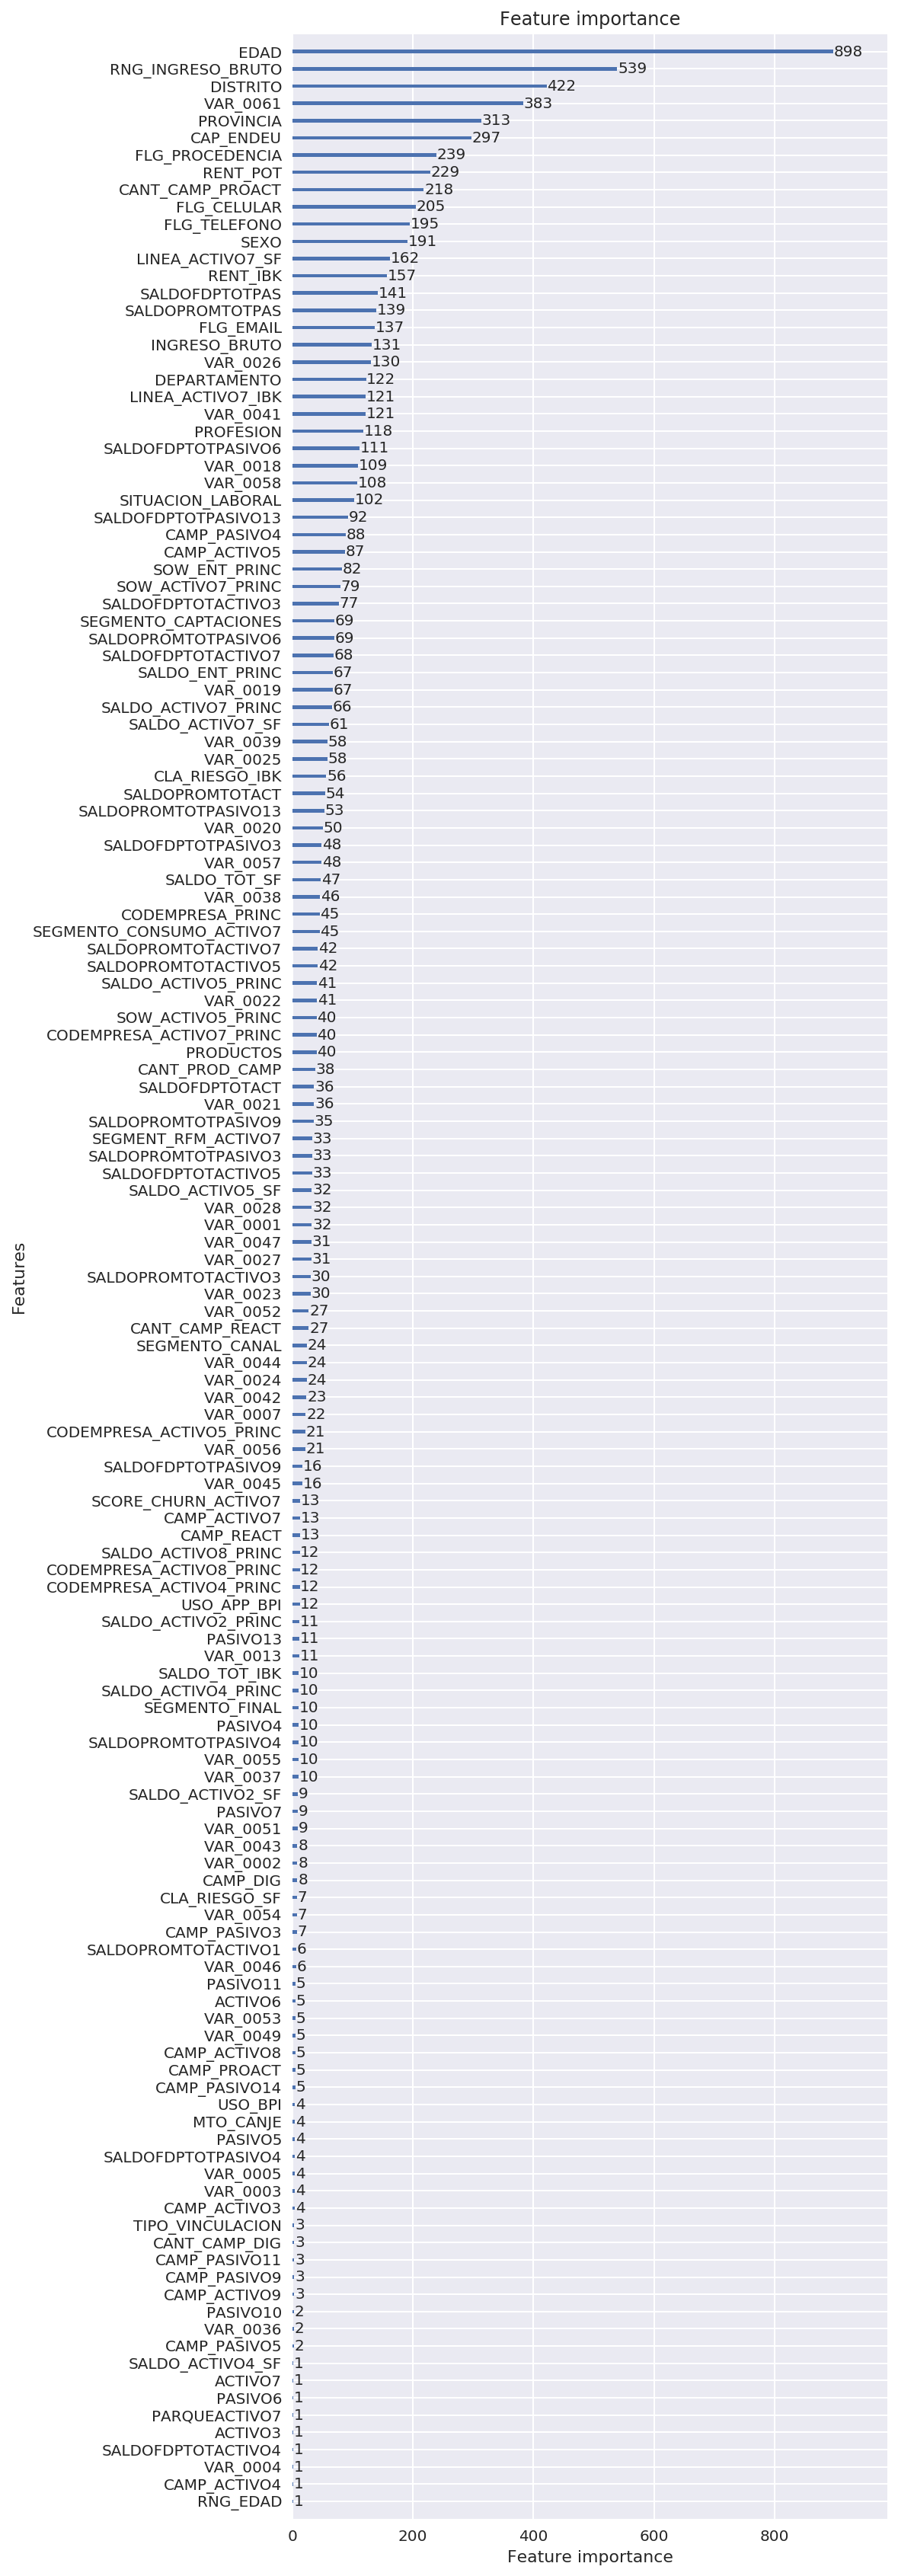

In [113]:
plot_importance(lgbm, figsize=(7,30))

In [108]:
results

,dataset,model,params,valid_logloss,valid_logloss_std,train_logloss,train_logloss_std,logloss_diff,time
0,baseline,CatBoostClassifier,no-params,0.584286,0.009260,0.526380,0.003921,0.057906,128.10
1,baseline,CatBoostClassifier,no-params,0.585693,0.009054,0.507265,0.007852,0.078428,74.61
2,baseline,CatBoostClassifier,no-params,0.623721,0.008273,0.609965,0.002344,0.013756,45.08
3,baseline,RandomForestClassifier,no-params,0.747305,0.013300,0.212645,0.001055,0.534660,4.42
4,baseline,RandomForestClassifier,no-params,0.737852,0.016355,0.214688,0.001089,0.523164,4.48
5,baseline,RandomForestClassifier,no-params,0.630898,0.007733,0.421036,0.001610,0.209862,15.04
6,baseline,RandomForestClassifier,no-params,0.619316,0.005065,0.596710,0.001328,0.022607,14.07
7,baseline,LGBMClassifier,no-params,0.578379,0.008157,0.462663,0.004712,0.115716,6.20


In [90]:
results

,dataset,model,params,valid_logloss,valid_logloss_std,train_logloss,train_logloss_std,logloss_diff,time
0,baseline,CatBoostClassifier,no-params,0.584286,0.009260,0.526380,0.003921,0.057906,128.10
1,baseline,CatBoostClassifier,no-params,0.585693,0.009054,0.507265,0.007852,0.078428,74.61
2,baseline,CatBoostClassifier,no-params,0.623721,0.008273,0.609965,0.002344,0.013756,45.08
3,baseline,RandomForestClassifier,no-params,0.747305,0.013300,0.212645,0.001055,0.534660,4.42
4,baseline,RandomForestClassifier,no-params,0.737852,0.016355,0.214688,0.001089,0.523164,4.48
5,baseline,RandomForestClassifier,no-params,0.630898,0.007733,0.421036,0.001610,0.209862,15.04
6,baseline,RandomForestClassifier,no-params,0.619316,0.005065,0.596710,0.001328,0.022607,14.07


In [84]:
results

,dataset,model,params,valid_logloss,valid_logloss_std,train_logloss,train_logloss_std,logloss_diff,time
0,baseline,CatBoostClassifier,no-params,0.584286,0.009260,0.526380,0.003921,0.057906,128.10
1,baseline,CatBoostClassifier,no-params,0.585693,0.009054,0.507265,0.007852,0.078428,74.61
2,baseline,CatBoostClassifier,no-params,0.623721,0.008273,0.609965,0.002344,0.013756,45.08
3,baseline,RandomForestClassifier,no-params,0.747305,0.013300,0.212645,0.001055,0.534660,4.42


In [78]:
results

,dataset,model,params,valid_logloss,valid_logloss_std,train_logloss,train_logloss_std,logloss_diff,time
0,baseline,CatBoostClassifier,no-params,0.584286,0.009260,0.526380,0.003921,0.057906,128.10
1,baseline,CatBoostClassifier,no-params,0.585693,0.009054,0.507265,0.007852,0.078428,74.61
2,baseline,CatBoostClassifier,no-params,0.623721,0.008273,0.609965,0.002344,0.013756,45.08


In [47]:
results

,dataset,model,params,valid_logloss,valid_logloss_std,train_logloss,train_logloss_std,logloss_diff,time
0,baseline,CatBoostClassifier,no-params,0.584286,0.00926,0.52638,0.003921,0.057906,128.1


In [33]:
results

,dataset,model,params,valid_logloss,valid_logloss_std,train_logloss,train_logloss_std,logloss_diff,time
0,baseline,CatBoostClassifier,no-params,0.599284,0.008136,0.563075,0.004216,0.036209,68.85


In [48]:
y_test

array([[0.50371139, 0.49628861, 0.        ],
       [0.56298209, 0.43701791, 0.        ],
       [0.85231054, 0.14768946, 0.        ],
       ...,
       [0.72852131, 0.27147869, 0.        ],
       [0.66805795, 0.33194205, 0.        ],
       [0.52816278, 0.47183722, 0.        ]])

## Submission

In [247]:
test['PROB_CANAL_1'] = y_test[:,0]
test['PROB_CANAL_2'] = y_test[:,1]
test['PROB_CANAL_3'] = y_test[:,2]

In [248]:
test.head()

,MES,DOCUMENTOIDENT,CODIGOSF,CODIGOCLIENTE,PROB_CANAL_1,PROB_CANAL_2,PROB_CANAL_3,EDAD,FLG_CELULAR,FLG_EMAIL,FLG_TELEFONO,CAMP_ACTIVO1,CAMP_ACTIVO2,CAMP_PASIVO14,CAMP_PASIVO3,CAMP_DIG,CAMP_ACTIVO3,CAMP_PASIVO4,CAMP_ACTIVO4,CAMP_ACTIVO9,CAMP_PASIVO9,CAMP_PASIVO5,CAMP_PASIVO8,CAMP_ACTIVO5,CAMP_PROACT,CAMP_REACT,CAMP_PASIVO11,CAMP_ACTIVO7,CAMP_ACTIVO8,CANT_CAMP_DIG,CANT_CAMP_PROACT,CANT_CAMP_REACT,CANT_PROD_CAMP,FLG_CAMP,VAR_0001,VAR_0002,VAR_0003,VAR_0004,VAR_0005,VAR_0006,VAR_0007,VAR_0008,VAR_0013,VAR_0018,VAR_0019,VAR_0020,VAR_0021,VAR_0022,VAR_0023,VAR_0024,VAR_0025,VAR_0026,VAR_0027,VAR_0028,VAR_0033,VAR_0035,VAR_0036,VAR_0037,VAR_0038,VAR_0039,VAR_0041,VAR_0042,VAR_0043,VAR_0044,VAR_0045,VAR_0046,VAR_0047,VAR_0048,VAR_0049,VAR_0050,VAR_0051,VAR_0052,VAR_0053,VAR_0054,VAR_0055,VAR_0056,VAR_0061,ACTIVO1,PASIVO1,PASIVO2,CANT_CANJES,ACTIVO2,PASIVO3,RENT_IBK,RENT_POT,SALDOFDPTOTACT,SALDOFDPTOTACTIVO1,SALDOFDPTOTPASIVO1,SALDOFDPTOTACTIVO2,SALDOFDPTOTPASIVO3,SALDOFDPTOTACTIVO3,SALDOFDPTOTPASIVO4,SALDOFDPTOTACTIVO4,SALDOFDPTOTACTIVO5,SALDOFDPTOTPASIVO9,SALDOFDPTOTPAS,SALDOFDPTOTPASIVO6,SALDOFDPTOTPASIVO8,SALDOFDPTOTACTIVO7,SALDOFDPTOTPASIVO13,SALDOFDPTOTACTIVO8,SALDOFDPVIGACT,SALDOFDPVIGACTIVO2,SALDOPROMTOTACT,SALDOPROMTOTACTIVO1,SALDOPROMTOTPASIVO1,SALDOPROMTOTACTIVO2,SALDOPROMTOTPASIVO3,SALDOPROMTOTACTIVO3,SALDOPROMTOTPASIVO4,SALDOPROMTOTACTIVO4,SALDOPROMTOTACTIVO5,SALDOPROMTOTPASIVO9,SALDOPROMTOTPAS,SALDOPROMTOTPASIVO6,SALDOPROMTOTPASIVO8,SALDOPROMTOTACTIVO7,SALDOPROMTOTPASIVO13,SALDOPROMTOTACTIVO8,SALDOPROMVIGACT,SALDOPROMVIGACTIVO2,SALDOPROMVIGACTIVO7,ACTIVO3,PASIVO4,PASIVO5,PARQUEACTIVO7,PASIVO6,PASIVO7,PASIVO8,ACTIVO4,INGRESO_BRUTO,ACTIVO5,PASIVO9,PASIVO10,ACTIVO6,PASIVO11,PRODUCTOS,PASIVO12,MTO_CANJE,PASIVO13,ACTIVO7,USO_APP,USO_APP_BPI,USO_BPI,USO_DIG,ACTIVO8,FLG_CANJE,CASTIGADO,CAP_ENDEU,CLA_RIESGO_IBK2,CLA_RIESGO_SF,CODEMPRESA_ACTIVO2_PRINC,CODEMPRESA_ACTIVO4_PRINC,CODEMPRESA_ACTIVO5_PRINC,CODEMPRESA_PRINC,CODEMPRESA_ACTIVO7_PRINC,CODEMPRESA_ACTIVO8_PRINC,LINEA_ACTIVO7_IBK,LINEA_ACTIVO7_SF,FLG_ACTIVO2_SF,FLG_ACTIVO4_SF,FLG_ACTIVO5_SF,FLG_ACTIVO7_SF,FLG_ACTIVO8_SF,SALDO_ACTIVO2_PRINC,SALDO_ACTIVO2_SF,SALDO_ENT_PRINC,SALDO_ACTIVO4_PRINC,SALDO_ACTIVO4_SF,SALDO_ACTIVO5_PRINC,SALDO_ACTIVO5_SF,SALDO_ACTIVO7_PRINC,SALDO_ACTIVO7_SF,SALDO_TOT_IBK,SALDO_TOT_SF,SALDO_ACTIVO8_PRINC,SALDO_ACTIVO8_SF,SOBREENDEUDADO,SOW_ACTIVO2_PRINC,SOW_ENT_PRINC,SOW_ACTIVO4_PRINC,SOW_ACTIVO5_PRINC,SOW_ACTIVO7_PRINC,DISTRITO-TG2,DISTRITO-TG1,DISTRITO-TG3,DEPARTAMENTO-TG2,DEPARTAMENTO-TG1,DEPARTAMENTO-TG3,FLG_PROCEDENCIA-TG2,FLG_PROCEDENCIA-TG1,FLG_PROCEDENCIA-TG3,SEGMENTO_FINAL-TG2,SEGMENTO_FINAL-TG1,SEGMENTO_FINAL-TG3,PROVINCIA-TG2,PROVINCIA-TG1,PROVINCIA-TG3,SEXO-TG2,SEXO-TG1,SEXO-TG3,SEGMENTO_CAPTACIONES-TG2,SEGMENTO_CAPTACIONES-TG1,SEGMENTO_CAPTACIONES-TG3,SEGMENTO_CONSUMO_ACTIVO7-TG2,SEGMENTO_CONSUMO_ACTIVO7-TG1,SEGMENTO_CONSUMO_ACTIVO7-TG3,TIPO_VINCULACION-TG2,TIPO_VINCULACION-TG1,TIPO_VINCULACION-TG3,SEGMENTO_CANAL-TG2,SEGMENTO_CANAL-TG1,SEGMENTO_CANAL-TG3,RNG_EDAD-TG2,RNG_EDAD-TG1,RNG_EDAD-TG3,SCORE_CHURN_ACTIVO7-TG2,SCORE_CHURN_ACTIVO7-TG1,SCORE_CHURN_ACTIVO7-TG3,SITUACION_LABORAL-TG2,SITUACION_LABORAL-TG1,SITUACION_LABORAL-TG3,SEGMENT_RFM_ACTIVO7-TG2,SEGMENT_RFM_ACTIVO7-TG1,SEGMENT_RFM_ACTIVO7-TG3,BANCARIZADO-TG2,BANCARIZADO-TG1,BANCARIZADO-TG3,VAR_0058-TG2,VAR_0058-TG1,VAR_0058-TG3,PROFESION-TG2,PROFESION-TG1,PROFESION-TG3,VAR_0057-TG2,VAR_0057-TG1,VAR_0057-TG3,RNG_INGRESO_BRUTO-TG2,RNG_INGRESO_BRUTO-TG1,RNG_INGRESO_BRUTO-TG3,CLA_RIESGO_IBK-TG2,CLA_RIESGO_IBK-TG1,CLA_RIESGO_IBK-TG3
0,201712,IBK_DNI00027914559,IBK_CODSBS00027914559,IBK_CODUNICO00027914559,0.520265,0.476714,0.003021,40,1,1,1,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,2.0,1.0,5.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,900.00000,6.0,5.0,1.0,5.0,1.0,0.0,27.0,8.0,27.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,820.000,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.702986,0.0,0.0,0.0,0.0,0.0,0.0,-152.783,1273.750,2631.63,0.0,0.0,0.0,0.0,2397.94,0

In [234]:
# Mean encoding LGBM
test.head()

,MES,DOCUMENTOIDENT,CODIGOSF,CODIGOCLIENTE,PROB_CANAL_1,PROB_CANAL_2,PROB_CANAL_3,EDAD,FLG_CELULAR,FLG_EMAIL,FLG_TELEFONO,CAMP_ACTIVO1,CAMP_ACTIVO2,CAMP_PASIVO14,CAMP_PASIVO3,CAMP_DIG,CAMP_ACTIVO3,CAMP_PASIVO4,CAMP_ACTIVO4,CAMP_ACTIVO9,CAMP_PASIVO9,CAMP_PASIVO5,CAMP_PASIVO8,CAMP_ACTIVO5,CAMP_PROACT,CAMP_REACT,CAMP_PASIVO11,CAMP_ACTIVO7,CAMP_ACTIVO8,CANT_CAMP_DIG,CANT_CAMP_PROACT,CANT_CAMP_REACT,CANT_PROD_CAMP,FLG_CAMP,VAR_0001,VAR_0002,VAR_0003,VAR_0004,VAR_0005,VAR_0006,VAR_0007,VAR_0008,VAR_0013,VAR_0018,VAR_0019,VAR_0020,VAR_0021,VAR_0022,VAR_0023,VAR_0024,VAR_0025,VAR_0026,VAR_0027,VAR_0028,VAR_0033,VAR_0035,VAR_0036,VAR_0037,VAR_0038,VAR_0039,VAR_0041,VAR_0042,VAR_0043,VAR_0044,VAR_0045,VAR_0046,VAR_0047,VAR_0048,VAR_0049,VAR_0050,VAR_0051,VAR_0052,VAR_0053,VAR_0054,VAR_0055,VAR_0056,VAR_0061,ACTIVO1,PASIVO1,PASIVO2,CANT_CANJES,ACTIVO2,PASIVO3,RENT_IBK,RENT_POT,SALDOFDPTOTACT,SALDOFDPTOTACTIVO1,SALDOFDPTOTPASIVO1,SALDOFDPTOTACTIVO2,SALDOFDPTOTPASIVO3,SALDOFDPTOTACTIVO3,SALDOFDPTOTPASIVO4,SALDOFDPTOTACTIVO4,SALDOFDPTOTACTIVO5,SALDOFDPTOTPASIVO9,SALDOFDPTOTPAS,SALDOFDPTOTPASIVO6,SALDOFDPTOTPASIVO8,SALDOFDPTOTACTIVO7,SALDOFDPTOTPASIVO13,SALDOFDPTOTACTIVO8,SALDOFDPVIGACT,SALDOFDPVIGACTIVO2,SALDOPROMTOTACT,SALDOPROMTOTACTIVO1,SALDOPROMTOTPASIVO1,SALDOPROMTOTACTIVO2,SALDOPROMTOTPASIVO3,SALDOPROMTOTACTIVO3,SALDOPROMTOTPASIVO4,SALDOPROMTOTACTIVO4,SALDOPROMTOTACTIVO5,SALDOPROMTOTPASIVO9,SALDOPROMTOTPAS,SALDOPROMTOTPASIVO6,SALDOPROMTOTPASIVO8,SALDOPROMTOTACTIVO7,SALDOPROMTOTPASIVO13,SALDOPROMTOTACTIVO8,SALDOPROMVIGACT,SALDOPROMVIGACTIVO2,SALDOPROMVIGACTIVO7,ACTIVO3,PASIVO4,PASIVO5,PARQUEACTIVO7,PASIVO6,PASIVO7,PASIVO8,ACTIVO4,INGRESO_BRUTO,ACTIVO5,PASIVO9,PASIVO10,ACTIVO6,PASIVO11,PRODUCTOS,PASIVO12,MTO_CANJE,PASIVO13,ACTIVO7,USO_APP,USO_APP_BPI,USO_BPI,USO_DIG,ACTIVO8,FLG_CANJE,CASTIGADO,CAP_ENDEU,CLA_RIESGO_IBK2,CLA_RIESGO_SF,CODEMPRESA_ACTIVO2_PRINC,CODEMPRESA_ACTIVO4_PRINC,CODEMPRESA_ACTIVO5_PRINC,CODEMPRESA_PRINC,CODEMPRESA_ACTIVO7_PRINC,CODEMPRESA_ACTIVO8_PRINC,LINEA_ACTIVO7_IBK,LINEA_ACTIVO7_SF,FLG_ACTIVO2_SF,FLG_ACTIVO4_SF,FLG_ACTIVO5_SF,FLG_ACTIVO7_SF,FLG_ACTIVO8_SF,SALDO_ACTIVO2_PRINC,SALDO_ACTIVO2_SF,SALDO_ENT_PRINC,SALDO_ACTIVO4_PRINC,SALDO_ACTIVO4_SF,SALDO_ACTIVO5_PRINC,SALDO_ACTIVO5_SF,SALDO_ACTIVO7_PRINC,SALDO_ACTIVO7_SF,SALDO_TOT_IBK,SALDO_TOT_SF,SALDO_ACTIVO8_PRINC,SALDO_ACTIVO8_SF,SOBREENDEUDADO,SOW_ACTIVO2_PRINC,SOW_ENT_PRINC,SOW_ACTIVO4_PRINC,SOW_ACTIVO5_PRINC,SOW_ACTIVO7_PRINC,DISTRITO-TG2,DISTRITO-TG1,DISTRITO-TG3,DEPARTAMENTO-TG2,DEPARTAMENTO-TG1,DEPARTAMENTO-TG3,FLG_PROCEDENCIA-TG2,FLG_PROCEDENCIA-TG1,FLG_PROCEDENCIA-TG3,SEGMENTO_FINAL-TG2,SEGMENTO_FINAL-TG1,SEGMENTO_FINAL-TG3,PROVINCIA-TG2,PROVINCIA-TG1,PROVINCIA-TG3,SEXO-TG2,SEXO-TG1,SEXO-TG3,SEGMENTO_CAPTACIONES-TG2,SEGMENTO_CAPTACIONES-TG1,SEGMENTO_CAPTACIONES-TG3,SEGMENTO_CONSUMO_ACTIVO7-TG2,SEGMENTO_CONSUMO_ACTIVO7-TG1,SEGMENTO_CONSUMO_ACTIVO7-TG3,TIPO_VINCULACION-TG2,TIPO_VINCULACION-TG1,TIPO_VINCULACION-TG3,SEGMENTO_CANAL-TG2,SEGMENTO_CANAL-TG1,SEGMENTO_CANAL-TG3,RNG_EDAD-TG2,RNG_EDAD-TG1,RNG_EDAD-TG3,SCORE_CHURN_ACTIVO7-TG2,SCORE_CHURN_ACTIVO7-TG1,SCORE_CHURN_ACTIVO7-TG3,SITUACION_LABORAL-TG2,SITUACION_LABORAL-TG1,SITUACION_LABORAL-TG3,SEGMENT_RFM_ACTIVO7-TG2,SEGMENT_RFM_ACTIVO7-TG1,SEGMENT_RFM_ACTIVO7-TG3,BANCARIZADO-TG2,BANCARIZADO-TG1,BANCARIZADO-TG3,VAR_0058-TG2,VAR_0058-TG1,VAR_0058-TG3,PROFESION-TG2,PROFESION-TG1,PROFESION-TG3,VAR_0057-TG2,VAR_0057-TG1,VAR_0057-TG3,RNG_INGRESO_BRUTO-TG2,RNG_INGRESO_BRUTO-TG1,RNG_INGRESO_BRUTO-TG3,CLA_RIESGO_IBK-TG2,CLA_RIESGO_IBK-TG1,CLA_RIESGO_IBK-TG3
0,201712,IBK_DNI00027914559,IBK_CODSBS00027914559,IBK_CODUNICO00027914559,0.509767,0.488216,0.002017,40,1,1,1,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,2.0,1.0,5.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,900.00000,6.0,5.0,1.0,5.0,1.0,0.0,27.0,8.0,27.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,820.000,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.702986,0.0,0.0,0.0,0.0,0.0,0.0,-152.783,1273.750,2631.63,0.0,0.0,0.0,0.0,2397.94,0

In [50]:
test.head()

,MES,DOCUMENTOIDENT,CODIGOSF,CODIGOCLIENTE,PROB_CANAL_1,PROB_CANAL_2,PROB_CANAL_3,DISTRITO,EDAD,DEPARTAMENTO,FLG_CELULAR,FLG_EMAIL,FLG_PROCEDENCIA,FLG_TELEFONO,RNG_EDAD,RNG_INGRESO_BRUTO,PROVINCIA,PROFESION,SEXO,SITUACION_LABORAL,CAMP_ACTIVO1,CAMP_ACTIVO2,CAMP_PASIVO14,CAMP_PASIVO3,CAMP_DIG,CAMP_ACTIVO3,CAMP_PASIVO4,CAMP_ACTIVO4,CAMP_ACTIVO9,CAMP_PASIVO9,CAMP_PASIVO5,CAMP_PASIVO8,CAMP_ACTIVO5,CAMP_PROACT,CAMP_REACT,CAMP_PASIVO11,CAMP_ACTIVO7,CAMP_PASIVO13,CAMP_ACTIVO8,CANT_CAMP_DIG,CANT_CAMP_PROACT,CANT_CAMP_REACT,CANT_PROD_CAMP,FLG_CAMP,VAR_0001,VAR_0002,VAR_0003,VAR_0004,VAR_0005,VAR_0006,VAR_0007,VAR_0008,VAR_0009,VAR_0010,VAR_0011,VAR_0012,VAR_0013,VAR_0014,VAR_0015,VAR_0016,VAR_0017,VAR_0018,VAR_0019,VAR_0020,VAR_0021,VAR_0022,VAR_0023,VAR_0024,VAR_0025,VAR_0026,VAR_0027,VAR_0028,VAR_0033,VAR_0034,VAR_0035,VAR_0036,VAR_0037,VAR_0038,VAR_0039,VAR_0040,VAR_0041,VAR_0042,VAR_0043,VAR_0044,VAR_0045,VAR_0046,VAR_0047,VAR_0048,VAR_0049,VAR_0050,VAR_0051,VAR_0052,VAR_0053,VAR_0054,VAR_0055,VAR_0056,VAR_0057,VAR_0058,VAR_0061,ACTIVO1,PASIVO1,PASIVO2,BANCARIZADO,CANT_CANJES,ACTIVO2,PASIVO3,RENT_IBK,RENT_POT,SALDOFDPTOTACT,SALDOFDPTOTACTIVO1,SALDOFDPTOTPASIVO1,SALDOFDPTOTACTIVO2,SALDOFDPTOTPASIVO3,SALDOFDPTOTACTIVO3,SALDOFDPTOTPASIVO4,SALDOFDPTOTACTIVO4,SALDOFDPTOTACTIVO5,SALDOFDPTOTPASIVO9,SALDOFDPTOTPAS,SALDOFDPTOTPASIVO6,SALDOFDPTOTPASIVO8,SALDOFDPTOTACTIVO7,SALDOFDPTOTPASIVO13,SALDOFDPTOTACTIVO8,SALDOFDPVIGACT,SALDOFDPVIGACTIVO1,SALDOFDPVIGACTIVO2,SALDOFDPVIGACTIVO3,SALDOFDPVIGACTIVO4,SALDOFDPVIGACTIVO5,SALDOFDPVIGACTIVO7,SALDOFDPVIGACTIVO8,SALDOPROMTOTACT,SALDOPROMTOTACTIVO1,SALDOPROMTOTPASIVO1,SALDOPROMTOTACTIVO2,SALDOPROMTOTPASIVO3,SALDOPROMTOTACTIVO3,SALDOPROMTOTPASIVO4,SALDOPROMTOTACTIVO4,SALDOPROMTOTACTIVO5,SALDOPROMTOTPASIVO9,SALDOPROMTOTPAS,SALDOPROMTOTPASIVO6,SALDOPROMTOTPASIVO8,SALDOPROMTOTACTIVO7,SALDOPROMTOTPASIVO13,SALDOPROMTOTACTIVO8,SALDOPROMVIGACT,SALDOPROMVIGACTIVO1,SALDOPROMVIGACTIVO2,SALDOPROMVIGACTIVO3,SALDOPROMVIGACTIVO4,SALDOPROMVIGACTIVO5,SALDOPROMVIGACTIVO7,SALDOPROMVIGACTIVO8,ACTIVO3,PASIVO4,PASIVO5,PARQUEACTIVO7,PASIVO6,PASIVO7,PASIVO8,ACTIVO4,INGRESO_BRUTO,ACTIVO5,PASIVO9,PASIVO10,SCORE_CHURN_ACTIVO7,SEGMENTO_CANAL,SEGMENTO_CAPTACIONES,SEGMENTO_CONSUMO_ACTIVO7,SEGMENTO_FINAL,SEGMENT_RFM_ACTIVO7,ACTIVO6,PASIVO11,PRODUCTOS,PASIVO12,MTO_CANJE,TIPO_VINCULACION,PASIVO13,ACTIVO7,USO_APP,USO_APP_BPI,USO_BPI,USO_DIG,ACTIVO8,FLG_CANJE,CASTIGADO,CAP_ENDEU,CLA_RIESGO_IBK,CLA_RIESGO_IBK2,CLA_RIESGO_SF,CODEMPRESA_ACTIVO2_PRINC,CODEMPRESA_ACTIVO4_PRINC,CODEMPRESA_ACTIVO5_PRINC,CODEMPRESA_PRINC,CODEMPRESA_ACTIVO7_PRINC,CODEMPRESA_ACTIVO8_PRINC,LINEA_ACTIVO7_IBK,LINEA_ACTIVO7_SF,FLG_ACTIVO2_SF,FLG_ACTIVO4_SF,FLG_ACTIVO5_SF,FLG_ACTIVO7_SF,FLG_ACTIVO8_SF,SALDO_ACTIVO2_PRINC,SALDO_ACTIVO2_SF,SALDO_ENT_PRINC,SALDO_ACTIVO4_PRINC,SALDO_ACTIVO4_SF,SALDO_ACTIVO5_PRINC,SALDO_ACTIVO5_SF,SALDO_ACTIVO7_PRINC,SALDO_ACTIVO7_SF,SALDO_TOT_IBK,SALDO_TOT_SF,SALDO_ACTIVO8_PRINC,SALDO_ACTIVO8_SF,SOBREENDEUDADO,SOW_ACTIVO2_PRINC,SOW_ENT_PRINC,SOW_ACTIVO4_PRINC,SOW_ACTIVO5_PRINC,SOW_ACTIVO7_PRINC,SOW_ACTIVO8_PRINC
0,201712,IBK_DNI00027914559,IBK_CODSBS00027914559,IBK_CODUNICO00027914559,0.503711,0.496289,0.0,22,40,3,1,1,2,1,1,2,8,0,2,0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,2.0,1.0,5.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,900.00000,6.0,5.0,1.0,5.0,1.0,0.0,27.0,8.0,27.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,820.000,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1,4,0.702986,0.0,0.0,0.0,2,0.0,0.0,0.0,-152.783,1273.750,2631.63,0.0,0.0,0.0,0.0,2397.94,0.0,0.0,0.0,0.0,1.23,1.23,0.0,2631.63,0.00,0.0,2631.63,0.0,0.0,2397.94,0.0,0.0,2631.63,0.0,2689.94,0.0,0.0,0.0,0.0,2454.75,0.0,0.0,0.0,0.0,261.13,261.13,0.0,2689.94,0.00,0.0,2689.94,0.0,0.0,2454.75,0.0,0.0,2689.94,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,2019.0,0.0,0.0,1.0,4,4,1,9,3,2,0.0,2.0,7.0,1.0,0.0,2,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,185.0,3,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,15397.9,54693.6,0.0,0.0,0.0,1.0,0.

In [249]:
log_loss(y_true, test[['PROB_CANAL_1', 'PROB_CANAL_2', 'PROB_CANAL_3']], labels=[0,1,2])

0.33872779087423205

In [238]:
log_loss(y_true, test[['PROB_CANAL_1', 'PROB_CANAL_2', 'PROB_CANAL_3']], labels=[0,1,2])

0.34577079240217784

In [239]:
y_pred_mod = test[['PROB_CANAL_1', 'PROB_CANAL_2', 'PROB_CANAL_3']].values

In [244]:
y_pred_mod = np.ones(y_pred_mod.shape)
log_loss(y_true, y_pred_mod, labels=[0,1,2])

1.0986122886681093

In [235]:
y_true = np.argmax(test[['PROB_CANAL_1', 'PROB_CANAL_2', 'PROB_CANAL_3']].values, axis=1)

In [55]:
test['PROB_CANAL_3'] = 1e-5

In [56]:
test.head()

,MES,DOCUMENTOIDENT,CODIGOSF,CODIGOCLIENTE,PROB_CANAL_1,PROB_CANAL_2,PROB_CANAL_3,DISTRITO,EDAD,DEPARTAMENTO,FLG_CELULAR,FLG_EMAIL,FLG_PROCEDENCIA,FLG_TELEFONO,RNG_EDAD,RNG_INGRESO_BRUTO,PROVINCIA,PROFESION,SEXO,SITUACION_LABORAL,CAMP_ACTIVO1,CAMP_ACTIVO2,CAMP_PASIVO14,CAMP_PASIVO3,CAMP_DIG,CAMP_ACTIVO3,CAMP_PASIVO4,CAMP_ACTIVO4,CAMP_ACTIVO9,CAMP_PASIVO9,CAMP_PASIVO5,CAMP_PASIVO8,CAMP_ACTIVO5,CAMP_PROACT,CAMP_REACT,CAMP_PASIVO11,CAMP_ACTIVO7,CAMP_PASIVO13,CAMP_ACTIVO8,CANT_CAMP_DIG,CANT_CAMP_PROACT,CANT_CAMP_REACT,CANT_PROD_CAMP,FLG_CAMP,VAR_0001,VAR_0002,VAR_0003,VAR_0004,VAR_0005,VAR_0006,VAR_0007,VAR_0008,VAR_0009,VAR_0010,VAR_0011,VAR_0012,VAR_0013,VAR_0014,VAR_0015,VAR_0016,VAR_0017,VAR_0018,VAR_0019,VAR_0020,VAR_0021,VAR_0022,VAR_0023,VAR_0024,VAR_0025,VAR_0026,VAR_0027,VAR_0028,VAR_0033,VAR_0034,VAR_0035,VAR_0036,VAR_0037,VAR_0038,VAR_0039,VAR_0040,VAR_0041,VAR_0042,VAR_0043,VAR_0044,VAR_0045,VAR_0046,VAR_0047,VAR_0048,VAR_0049,VAR_0050,VAR_0051,VAR_0052,VAR_0053,VAR_0054,VAR_0055,VAR_0056,VAR_0057,VAR_0058,VAR_0061,ACTIVO1,PASIVO1,PASIVO2,BANCARIZADO,CANT_CANJES,ACTIVO2,PASIVO3,RENT_IBK,RENT_POT,SALDOFDPTOTACT,SALDOFDPTOTACTIVO1,SALDOFDPTOTPASIVO1,SALDOFDPTOTACTIVO2,SALDOFDPTOTPASIVO3,SALDOFDPTOTACTIVO3,SALDOFDPTOTPASIVO4,SALDOFDPTOTACTIVO4,SALDOFDPTOTACTIVO5,SALDOFDPTOTPASIVO9,SALDOFDPTOTPAS,SALDOFDPTOTPASIVO6,SALDOFDPTOTPASIVO8,SALDOFDPTOTACTIVO7,SALDOFDPTOTPASIVO13,SALDOFDPTOTACTIVO8,SALDOFDPVIGACT,SALDOFDPVIGACTIVO1,SALDOFDPVIGACTIVO2,SALDOFDPVIGACTIVO3,SALDOFDPVIGACTIVO4,SALDOFDPVIGACTIVO5,SALDOFDPVIGACTIVO7,SALDOFDPVIGACTIVO8,SALDOPROMTOTACT,SALDOPROMTOTACTIVO1,SALDOPROMTOTPASIVO1,SALDOPROMTOTACTIVO2,SALDOPROMTOTPASIVO3,SALDOPROMTOTACTIVO3,SALDOPROMTOTPASIVO4,SALDOPROMTOTACTIVO4,SALDOPROMTOTACTIVO5,SALDOPROMTOTPASIVO9,SALDOPROMTOTPAS,SALDOPROMTOTPASIVO6,SALDOPROMTOTPASIVO8,SALDOPROMTOTACTIVO7,SALDOPROMTOTPASIVO13,SALDOPROMTOTACTIVO8,SALDOPROMVIGACT,SALDOPROMVIGACTIVO1,SALDOPROMVIGACTIVO2,SALDOPROMVIGACTIVO3,SALDOPROMVIGACTIVO4,SALDOPROMVIGACTIVO5,SALDOPROMVIGACTIVO7,SALDOPROMVIGACTIVO8,ACTIVO3,PASIVO4,PASIVO5,PARQUEACTIVO7,PASIVO6,PASIVO7,PASIVO8,ACTIVO4,INGRESO_BRUTO,ACTIVO5,PASIVO9,PASIVO10,SCORE_CHURN_ACTIVO7,SEGMENTO_CANAL,SEGMENTO_CAPTACIONES,SEGMENTO_CONSUMO_ACTIVO7,SEGMENTO_FINAL,SEGMENT_RFM_ACTIVO7,ACTIVO6,PASIVO11,PRODUCTOS,PASIVO12,MTO_CANJE,TIPO_VINCULACION,PASIVO13,ACTIVO7,USO_APP,USO_APP_BPI,USO_BPI,USO_DIG,ACTIVO8,FLG_CANJE,CASTIGADO,CAP_ENDEU,CLA_RIESGO_IBK,CLA_RIESGO_IBK2,CLA_RIESGO_SF,CODEMPRESA_ACTIVO2_PRINC,CODEMPRESA_ACTIVO4_PRINC,CODEMPRESA_ACTIVO5_PRINC,CODEMPRESA_PRINC,CODEMPRESA_ACTIVO7_PRINC,CODEMPRESA_ACTIVO8_PRINC,LINEA_ACTIVO7_IBK,LINEA_ACTIVO7_SF,FLG_ACTIVO2_SF,FLG_ACTIVO4_SF,FLG_ACTIVO5_SF,FLG_ACTIVO7_SF,FLG_ACTIVO8_SF,SALDO_ACTIVO2_PRINC,SALDO_ACTIVO2_SF,SALDO_ENT_PRINC,SALDO_ACTIVO4_PRINC,SALDO_ACTIVO4_SF,SALDO_ACTIVO5_PRINC,SALDO_ACTIVO5_SF,SALDO_ACTIVO7_PRINC,SALDO_ACTIVO7_SF,SALDO_TOT_IBK,SALDO_TOT_SF,SALDO_ACTIVO8_PRINC,SALDO_ACTIVO8_SF,SOBREENDEUDADO,SOW_ACTIVO2_PRINC,SOW_ENT_PRINC,SOW_ACTIVO4_PRINC,SOW_ACTIVO5_PRINC,SOW_ACTIVO7_PRINC,SOW_ACTIVO8_PRINC
0,201712,IBK_DNI00027914559,IBK_CODSBS00027914559,IBK_CODUNICO00027914559,0.503711,0.496289,0.00001,22,40,3,1,1,2,1,1,2,8,0,2,0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,2.0,1.0,5.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,900.00000,6.0,5.0,1.0,5.0,1.0,0.0,27.0,8.0,27.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,820.000,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1,4,0.702986,0.0,0.0,0.0,2,0.0,0.0,0.0,-152.783,1273.750,2631.63,0.0,0.0,0.0,0.0,2397.94,0.0,0.0,0.0,0.0,1.23,1.23,0.0,2631.63,0.00,0.0,2631.63,0.0,0.0,2397.94,0.0,0.0,2631.63,0.0,2689.94,0.0,0.0,0.0,0.0,2454.75,0.0,0.0,0.0,0.0,261.13,261.13,0.0,2689.94,0.00,0.0,2689.94,0.0,0.0,2454.75,0.0,0.0,2689.94,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,2019.0,0.0,0.0,1.0,4,4,1,9,3,2,0.0,2.0,7.0,1.0,0.0,2,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,185.0,3,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,15397.9,54693.6,0.0,0.0,0.0,1.

In [57]:
test.iloc[:,:7].to_csv('T1108_submission_CatBoost_e-5.csv', index=False)

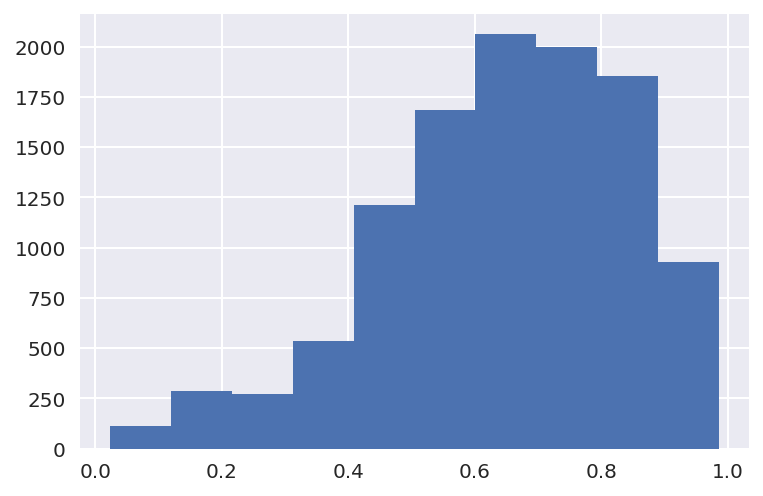

In [51]:
test.PROB_CANAL_1.hist()

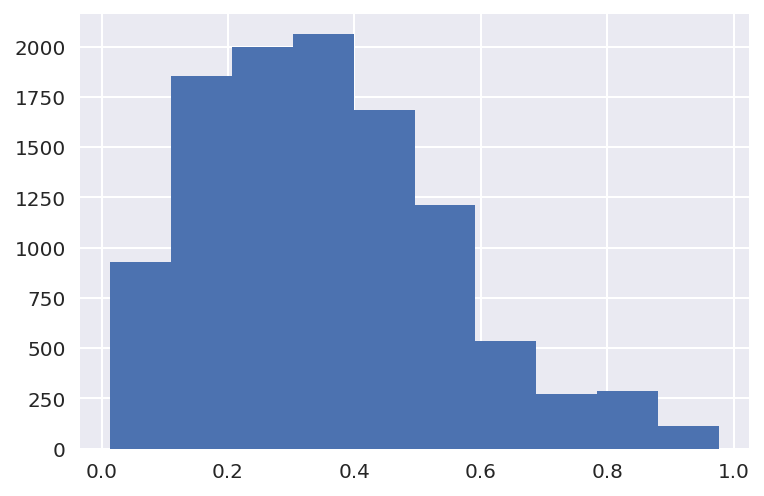

In [52]:
test.PROB_CANAL_2.hist()

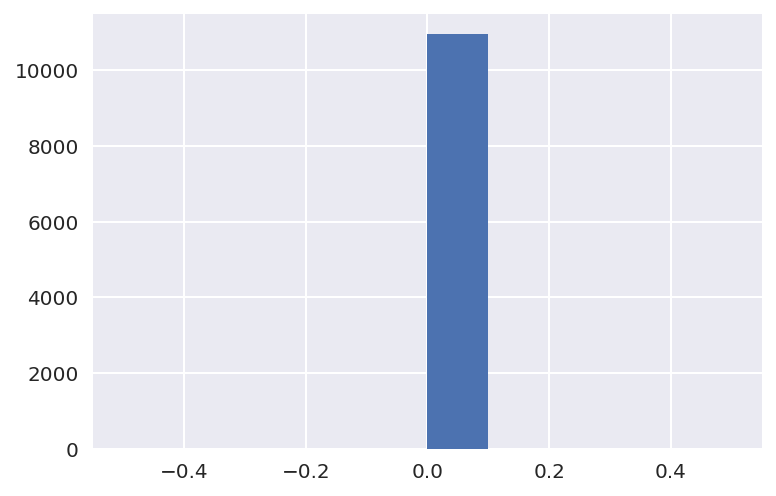

In [53]:
test.PROB_CANAL_3.hist()